# Library and Data Installation

In [1]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.
# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

You should consider upgrading via the 'c:\python37\python.exe -m pip install --upgrade pip' command.


torch:  1.9 ; cuda:  cpu
Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cpu/torch1.9/index.html


ERROR: Could not find a version that satisfies the requirement detectron2 (from versions: none)
ERROR: No matching distribution found for detectron2
You should consider upgrading via the 'c:\python37\python.exe -m pip install --upgrade pip' command.


In [ ]:
!git clone --branch v0.6 https://github.com/facebookresearch/detectron2.git detectron2_repo
# install detectron2 from source
!pip install -e detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 13559, done.
remote: Counting objects: 100% (1060/1060), done.
remote: Compressing objects: 100% (563/563), done.
remote: Total 13559 (delta 657), reused 819 (delta 488), pack-reused 12499
Receiving objects: 100% (13559/13559), 5.80 MiB | 16.60 MiB/s, done.
Resolving deltas: 100% (9613/9613), done.
Note: checking out 'd1e04565d3bec8719335b88be9e9b961bf3ec464'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

Obtaining file:///content/detectron2_repo
  Attempting uninstall: detectron2
    Found existing installation: detectron2 0.6+cu111
    Uninstalling detectron2-0.6+cu111:


In [ ]:
#!Restart runtime
#detectron2
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog

# PointRend project
from detectron2.projects import point_rend

#images
import cv2
from google.colab.patches import cv2_imshow
from PIL import Image

#other
import os, os.path
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt

#torch/torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms
from torch.autograd import Variable

#vision transformer


In [ ]:
#!wget https://www.di.ens.fr/willow/teaching/recvis18orig/assignment3/bird_dataset.zip
#!unzip /content/bird_dataset.zip
print("==============")
#if already created and downloaded cropped dataset run this to unzip
# skip section "Bird Detection and Cropped Dataset"
# go to section "Data Loading"

#!unzip /content/cropped_bird_dataset_no_square.zip
#print("==============")
#!unzip /content/cropped_bird_dataset.zip

# Detect and crop dataset

In [ ]:
class BirdDetectron2():
  """
  BirdDetectron2 : 
  Dects birds in images using the facebook/research library detectron2
  model_type options: 
    1. instance segmentation with mask_rcnn
    2. instance segmentation with point rending
    3. panoptic segmentation with fpn
  """
  def __init__(self, model_type = "IS"):
    self.cfg = get_cfg()
    self.model_type = model_type
    if self.model_type == "IS": #instance segmentation with mask rcnn
      self.cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml"))
      self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
    if self.model_type == "PR": #point rending
      point_rend.add_pointrend_config(self.cfg)
      self.cfg.merge_from_file("detectron2_repo/projects/PointRend/configs/InstanceSegmentation/pointrend_rcnn_X_101_32x8d_FPN_3x_coco.yaml")
      self.cfg.MODEL.WEIGHTS = "detectron2://PointRend/InstanceSegmentation/pointrend_rcnn_X_101_32x8d_FPN_3x_coco/28119989/model_final_ba17b9.pkl"
    if self.model_type == "PS": #panoptic segmentation
      self.cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
      self.cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")

    self.cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    self.cfg.MODEL.DEVICE = "cuda"
    self.predictor = DefaultPredictor(self.cfg)
    #parameters
    self.imagepath, self.image = "", None
    self.outputs, self.predictions, self.segmentInfo = None, None, None

  def update_predictor(self, image_path):
    self.imagepath = image_path
    self.image = cv2.imread(f"{self.imagepath}")
    if self.model_type != "PS":
      self.outputs = self.predictor(self.image)
    else:
      self.predictions, self.segmentInfo = self.predictor(self.image)["panoptic_seg"]

  def viz_seg(self, image_path):
    """vizualize the segmentation of the model on the image """
    self.update_predictor(image_path) #updates parameters
    if self.model_type != "PS":
      viz = Visualizer(self.image[:,:,::-1], MetadataCatalog.get(self.cfg.DATASETS.TRAIN[0])) #instance_mode=ColorMode.IMAGE_BW)
      output = viz.draw_instance_predictions(self.outputs["instances"].to("cpu"))
    else:
      viz = Visualizer(self.image[:,:,::-1], MetadataCatalog.get(self.cfg.DATASETS.TRAIN[0]))
      output = viz.draw_panoptic_seg_predictions(self.predictions.to("cpu"), self.segmentInfo)

    cv2_imshow(output.get_image()[:,:,::-1])



In [ ]:
#create 3 Birddetectron2 models
IS_model = BirdDetectron2(model_type="IS")
PR_model = BirdDetectron2(model_type="PR")
PS_model = BirdDetectron2(model_type="PS")

model_final_2d9806.pkl: 431MB [00:11, 36.0MB/s]                           
model_final_ba17b9.pkl: 495MB [00:17, 28.3MB/s]                           


WARNING [11/20 14:58:43 d2.projects.point_rend.mask_head]: Weight format of PointRend models have changed! Applying automatic conversion now ...


The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std
model_final_cafdb1.pkl: 261MB [00:10, 25.8MB/s]                           


In [ ]:
#parameters
square_crop = True
torch.cuda.is_available()

True

In [ ]:
# code taken from GeeksforGeeks to create a copy dataset without files
# https://www.geeksforgeeks.org/python-copy-directory-structure-without-files/

def create_copy_dataset(src, dst):
    src = os.path.abspath(src)
    src_prefix = len(src) + len(os.path.sep)
    os.makedirs(dst)
    for root, dirs, files in os.walk(src):
        for dirname in dirs:
            dirpath = os.path.join(dst, root[src_prefix:], dirname)
            os.mkdir(dirpath)

if not square_crop: 
  dst = '/content/cropped_bird_dataset_no_square'
else: 
  dst = '/content/cropped_bird_dataset'

create_copy_dataset('/content/bird_dataset', dst)

In [ ]:
# Bounding boxes for IS, PR, PS

def crop_bounding_box(box, image_path, square_crop=True):
    image = cv2.imread(f"{image_path}")
    left,top,right,bottom  = box #list/tupple
    height, width = image.shape[:2]
    if square_crop:
      center_x,center_y = (top+bottom)//2, (left+right)//2
      square_size = max(bottom-top, right-left)//2
      left, right = max(center_y - square_size,0) , min(center_y + square_size,width)
      top, bottom = max(center_x - square_size,0) , min(center_x + square_size, height)
      #print(left, top, right, bottom)
    return image[top:bottom, left:right]

def compute_box_IS_PR(out):
    out.scores[out.pred_classes.cpu().numpy() != 14] = 0
    best_bird_index = np.argmax(out.scores.cpu().numpy()).item()
    best_box = out.pred_boxes[best_bird_index]
    left,top,right,bottom = best_box.tensor.cpu().numpy()[0]
    left, top, right, bottom = np.floor(left), np.floor(top), np.ceil(right), np.ceil(bottom)
    return np.array([left, top, right, bottom]).astype("int") #final box

def compute_box_PS(predictions, bird_id):
  x, y = np.where(predictions.cpu() == bird_id)
  left = min(y)
  right = max(y)
  top = min(x)
  bottom = max(x)
  return np.array([left,top,right,bottom])

In [ ]:
def create_crop_dataset(squared = True):
  """
  Use IS_model to detect birds in images, crop them and 
  save them in a folder.
  return the paths of images not detected by IS_model
  """
  no_detect = {'train_images':[], 'val_images':[], 'test_images':[]}

  if not squared: name_root = '/content/cropped_bird_dataset_no_square'
  else: name_root = '/content/cropped_bird_dataset'

  for root,dirs,files in tqdm(os.walk("/content/bird_dataset")):
    if len(files)==0: continue
    else:
      for image_name in files:
        parent, testtrainval = os.path.split(os.path.split(root)[0])
        root2 = f"{name_root}/{testtrainval}/{os.path.split(root)[1]}"

        if os.path.isfile(f"{root2}/{image_name}"): continue #check if file is already cropped

        IS_model.update_predictor(f"{root}/{image_name}")
        out = IS_model.outputs["instances"]
        
        if 14 not in out.pred_classes: #14 is the class index of "bird" in COCO dataset
          no_detect[testtrainval].append(f"{root}/{image_name}")
        else:
          #takes care if we have multiple birds detected or other objects beside birds
          box = compute_box_IS_PR(out)
          #crop bird according to bounding box (square or not)
          cropped = crop_bounding_box(box,f"{root}/{image_name}", square_crop=squared)
          #cv2_imshow(cropped)
          #save image
          cv2.imwrite(f"{root2}/{image_name}", cropped)
  return no_detect



In [ ]:
#run
Detectionfails = create_crop_dataset(squared=square_crop)

In [ ]:
Detectionfails = {'train_images': ['/content/bird_dataset/train_images/004.Groove_billed_Ani/Groove_Billed_Ani_0080_1549.jpg', 
                  '/content/bird_dataset/train_images/028.Brown_Creeper/Brown_Creeper_0111_24590.jpg', 
                  '/content/bird_dataset/train_images/020.Yellow_breasted_Chat/Yellow_Breasted_Chat_0086_21877.jpg'], 
 'val_images': [], 
 'test_images': ['/content/bird_dataset/test_images/mistery_category/1b62fffcbf47a4f9e32b400edc662f1f.jpg', 
                 '/content/bird_dataset/test_images/mistery_category/fb97b3a7197b6f5f856782d39fa14f49.jpg', 
                 '/content/bird_dataset/test_images/mistery_category/8ede0bc5a4976385dcfe6e38feaf90c2.jpg', 
                 '/content/bird_dataset/test_images/mistery_category/4dd33eb8e7500905866f3067e11535e4.jpg', 
                 '/content/bird_dataset/test_images/mistery_category/0676b04fc9527343bee8ae5a2a9d4692.jpg']}


In [ ]:
def find_best_bird(L): #L=segmentInfo
  high_bird_id = 0 
  high_bird_score = -np.inf
  for i in range(len(L)):
    if L[i]['category_id']==14:
      if high_bird_score < L[i]['score']:
        high_bird_score = L[i]['score']
        high_bird_id = L[i]['id']
  return high_bird_id, high_bird_score


def crop_leftovers(squared = True):
  """ 
  Uses PR_model and PS_model to detect the images that IS_model did not detect.
  Takes the best bounding box with the highest score among all detected birds.
  returns the paths of images the models did not detect.
  """
  no_detect = {'train_images':[], 'val_images':[], 'test_images':[]}
  for k, img_paths in Detectionfails.items():
    print("Dataset: ", k)
    for img in img_paths:
      image = cv2.imread(f"{img}")
      PR_model.update_predictor(f"{img}")
      PS_model.update_predictor(f"{img}")
      out1 = PR_model.outputs["instances"]
      predictions2, segmentinfo2 = PS_model.predictions, PS_model.segmentInfo
      bird_id, bird_score = find_best_bird(segmentinfo2)
      
      if 14 not in out1.pred_classes:
        if bird_id:
          box = compute_box_PS(predictions2, bird_id)
        else:
          no_detect[k].append(img)
          continue
      else:
        if bird_id:
          out1.scores[out1.pred_classes.cpu().numpy() != 14] = 0
          bird_score1 = np.max(out1.scores.cpu().numpy()).item()
          if bird_score1 > bird_score:
            box = compute_box_IS_PR(out1)
          else:
            box = compute_box_PS(predictions2, bird_id)
        else:
          box = compute_box_IS_PR(out1)
      cropped = crop_bounding_box(box,f"{img}", square_crop=squared)
      #cv2_imshow(cropped)

      if squared:
        name_root = '/content/cropped_bird_dataset'
      else: 
        name_root = '/content/cropped_bird_dataset_no_square'

      _,category = os.path.split(os.path.split(img)[0])

      cv2.imwrite(f"{name_root}/{k}/{category}/{os.path.split(img)[1]}", cropped)
  return no_detect

In [ ]:
#run
no_detect = crop_leftovers(squared = True)

Dataset:  train_images


/content/detectron2_repo/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/content/detectron2_repo/projects/PointRend/point_rend/point_features.py:142: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  point_coords[:, :, 1] = h_step / 2.0 + (point

Dataset:  val_images
Dataset:  test_images


In [ ]:
#helper functions
def zip_dataset(squared=True):
  if not squared:
    !zip -r /content/cropped_bird_dataset_no_square.zip /content/cropped_bird_dataset_no_square
  else:
    !zip -r /content/cropped_bird_dataset.zip /content/cropped_bird_dataset
  print("Done zip.")

def download_dataset(squared=True):
  if not squared: name_root = '/content/cropped_bird_dataset_no_square'
  else: name_root = '/content/cropped_bird_dataset'
  from google.colab import files
  files.download(f"{name_root}.zip") #here delete '/content'
  print("Done download.")

Dataset: test_images


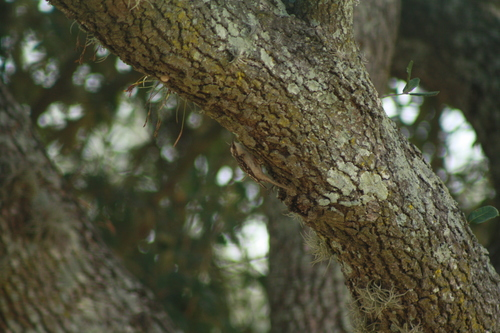

In [ ]:
Detectionfails2 = no_detect
for k,img_paths in Detectionfails2.items():
  if len(img_paths)==0: continue
  print("Dataset:",k)
  for img in img_paths:
    image = cv2.imread(f"{img}")
    cv2_imshow(image)
    _,category = os.path.split(os.path.split(img)[0])
    
    if not square_crop: name_root = '/content/cropped_bird_dataset_no_square'
    else: name_root = '/content/cropped_bird_dataset'
    #print(f"{name_root}/{k}/{category}/{os.path.split(img)[1]}")
    cv2.imwrite(f"{name_root}/{k}/{category}/{os.path.split(img)[1]}", image)


In [ ]:
# to save new dataset
#zip_dataset(squared = False)
#download_dataset(squared = square_crop)

In [ ]:
Detectionfailstmp = {'test_images': ['/content/bird_dataset/test_images/mistery_category/8ede0bc5a4976385dcfe6e38feaf90c2.jpg'],
 'train_images': [],
 'val_images': []}

# Model 

In [1]:
#images
import cv2
#from google.colab.patches import cv2_imshow
from PIL import Image

#other
import os, os.path
from tqdm import tqdm
import numpy as np
from matplotlib import pyplot as plt

#torch/torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms
from torch.autograd import Variable
from torchvision.utils import make_grid
#vision transformer
#https://pypi.org/project/timm/
#import timm
#!pip install timm

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        model_name = 'B_16_imagenet1k'
        self.vit = ViT(model_name, pretrained=True)
        for param in self.vit.parameters():
          param.requires_grad = False
        self.vit.fc = nn.Linear(768, 512)
        self.fc1 = nn.Linear(512, 20)

    def forward(self, x):
        x = F.relu(self.vit(x))
        x = self.fc1(x)
        return x

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
seed = 1
torch.manual_seed(seed)
if not os.path.isdir('./experiment'):
    os.makedirs('./experiment')
print(device)

cuda:0


In [5]:
#model = ViTClassification(0.1)
#model.to(device)
#model = Classifier(features_train.shape[1])

In [6]:
#!pip install --upgrade pytorch-pretrained-vit
from pytorch_pretrained_vit import ViT

In [7]:
model = Net()
model.to(device)

Loaded pretrained weights.


Net(
  (vit): ViT(
    (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (positional_embedding): PositionalEmbedding1D()
    (transformer): Transformer(
      (blocks): ModuleList(
        (0): Block(
          (attn): MultiHeadedSelfAttention(
            (proj_q): Linear(in_features=768, out_features=768, bias=True)
            (proj_k): Linear(in_features=768, out_features=768, bias=True)
            (proj_v): Linear(in_features=768, out_features=768, bias=True)
            (drop): Dropout(p=0.1, inplace=False)
          )
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (pwff): PositionWiseFeedForward(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (drop): Dropo

In [81]:

model_name = 'B_16_imagenet1k'
model = ViT(model_name, pretrained=True)
for param in model.parameters():
  param.requires_grad = False
model.fc = nn.Linear(768, 512)
model.fc2 = nn.Linear(512, 20)
model.to(device)

Loaded pretrained weights.


ViT(
  (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (positional_embedding): PositionalEmbedding1D()
  (transformer): Transformer(
    (blocks): ModuleList(
      (0): Block(
        (attn): MultiHeadedSelfAttention(
          (proj_q): Linear(in_features=768, out_features=768, bias=True)
          (proj_k): Linear(in_features=768, out_features=768, bias=True)
          (proj_v): Linear(in_features=768, out_features=768, bias=True)
          (drop): Dropout(p=0.1, inplace=False)
        )
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (pwff): PositionWiseFeedForward(
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (drop): Dropout(p=0.1, inplace=False)
      )
      (1): Block(
 

In [14]:
batch_size= 16
epochs = 30 #30
lr = 0.001 #0.001
momentum = 0.9 #SGD momentum
log_interval = 10 #how many batches to wait before logging training status
weight_decay = 3e-4 # 1e-3

In [53]:
#optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
#criterion = torch.nn.CrossEntropyLoss(reduction='mean')

optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)
#optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)
#lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)
#lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
criterion = torch.nn.CrossEntropyLoss()
#criterion = torch.nn.CrossEntropyLoss(reduction='mean') 

# Model 2

In [3]:
seed = 1
torch.manual_seed(seed)

# Optimize the parameters - crap ?

## Trial

In [8]:
#!pip install ax-platform

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.service.managed_loop import optimize
from ax.utils.notebook.plotting import render
from ax.utils.tutorials.cnn_utils import train, evaluate

In [9]:
nclasses = 20
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        model_name = 'B_16_imagenet1k'
        self.vit = ViT(model_name, pretrained=True)
        for param in self.vit.parameters():
          param.requires_grad = False
        self.vit.fc = nn.Linear(768, 512)
        self.fc1 = nn.Linear(512, 20)

    def forward(self, x):
        x = F.relu(self.vit(x))
        x = self.fc1(x)
        return x


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [11]:
print(device)

cuda:0


## Data Augmentation and Data Loading

In [26]:
if not os.path.isdir('./experiment'):
    os.makedirs('./experiment')

In [65]:
rm -r experiment/

In [67]:
#!unzip /content/cropped_bird_dataset_no_square.zip
print("==============")
#!unzip /content/cropped_bird_dataset.zip
print("Done")

Done


In [68]:
# data augmentation

In [4]:
val_trans = transforms.Compose([
    transforms.Resize((384, 384)),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomAutocontrast(p=0.5),
    transforms.ToTensor(),
    #transforms.RandomErasing(p=0.5),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

train_trans = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomAutocontrast(p=0.5),
    transforms.ToTensor(),
    #transforms.RandomErasing(p=0.5),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [5]:
batch_size = 16

In [6]:
#data transformation

#root = 'content/cropped_bird_dataset_no_square' #'cropped_bird_dataset', #cropped_bird_dataset_no_square

#data  = torch.utils.data.ConcatDataset([datasets.ImageFolder(f'{root}/train_images',transform=data_transforms),
 #                        datasets.ImageFolder(f'{root}/val_images', transform=data_transforms)])

#train_len = int(0.9*len(data))
#train_data, val_data = torch.utils.data.random_split(data,[train_len, len(data)-train_len],generator=torch.Generator().manual_seed(42))

#train_loader = torch.utils.data.DataLoader(train_data,
#    batch_size=batch_size, shuffle=True, num_workers=1)

#val_loader = torch.utils.data.DataLoader(val_data,
#    batch_size=batch_size, shuffle=False, num_workers=1)


In [7]:
root = 'content/cropped_bird_dataset_no_square' #'cropped_bird_dataset', #cropped_bird_dataset_no_square

train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(f'{root}/train_images',transform=train_trans),
    batch_size=batch_size, shuffle=True, num_workers=1)
val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder(f'{root}/val_images',transform=val_trans),
    batch_size=batch_size, shuffle=True, num_workers=1)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


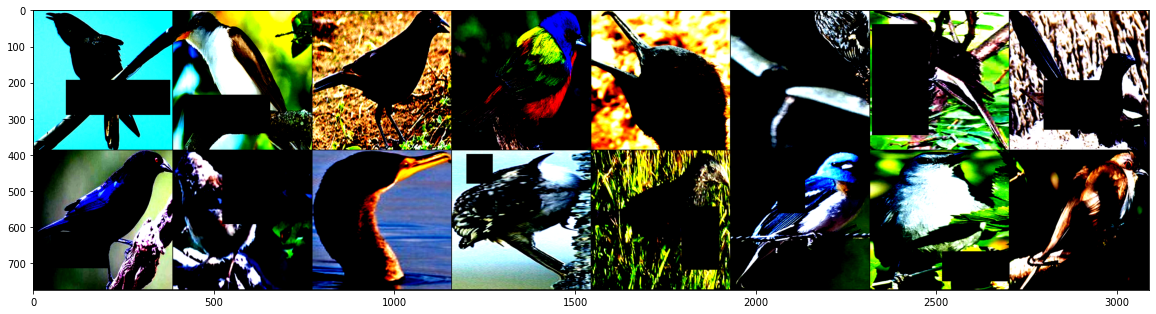

In [33]:
img, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))
plt.imshow(make_grid(img[:16],ncol=2).permute(1,2,0))
plt.show()

# crap yuhuu

In [19]:
def train(model, train_loader, parameters, dtype, device):
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), # or any optimizer you prefer 
                        lr=parameters.get("lr", 0.001), # 0.001 is used if no lr is specified
                        momentum=parameters.get("momentum", 0.9),
                        weight_decay=parameters.get("weight_decay", 3e-4))


    num_epochs = parameters.get("num_epochs", 3)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    for epoch in range(num_epochs):
      model.train()
      for batch_idx, (data, target) in enumerate(train_loader):
          #if use_cuda:
              #data, target = data.cuda(), target.cuda()
          data,target = data.to(device), target.to(device)
          optimizer.zero_grad()
          output = model(data)
          loss = criterion(output, target)
          loss.backward()
          optimizer.step()
          if batch_idx % log_interval == 0:
              print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                  epoch, batch_idx * len(data), len(train_loader.dataset),
                  100. * batch_idx / len(train_loader), loss.data.item()))
      scheduler.step()
    return model


def train_evaluate(parameterization):

    # constructing a new training data loader allows us to tune the batch size
    #train_loader = torch.utils.data.DataLoader(trainset,
    #                            batch_size=parameterization.get("batchsize", 32),
    #                            shuffle=True,
    #                            num_workers=1,
    #                            pin_memory=True)
    
    # Get neural net
    untrained_net = Net() 
    
    # train
    trained_net = train(model=untrained_net, train_loader=train_loader, 
                            parameters=parameterization, dtype=dtype, device=device)
    
    # return the accuracy of the model as it was trained in this run
    return evaluate(
        net=trained_net,
        data_loader=val_loader,
        dtype=dtype,
        device=device,
    )

In [20]:
dtype = torch.float
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

best_parameters, values, experiment, model = optimize(
    parameters=[
        {"name": "lr", "type": "range", "bounds": [1e-6, 0.4], "log_scale": True},
        {"name": "weight_decay", "type": "range", "bounds": [1e-6, 0.4], "log_scale": True},
        #{"name": "batchsize", "type": "range", "bounds": [16, 128]},
        {"name": "momentum", "type": "range", "bounds": [0.0, 1.0]},
        #{"name": "max_epoch", "type": "range", "bounds": [1, 30]},
        #{"name": "stepsize", "type": "range", "bounds": [20, 40]},        
    ],
  
    evaluation_function=train_evaluate,
    objective_name='accuracy',
)

print(best_parameters)
means, covariances = values
print(means)
print(covariances)

[INFO 11-22 21:29:14] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter lr. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 11-22 21:29:14] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter weight_decay. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 11-22 21:29:14] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter momentum. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 11-22 21:29:14] ax.modelbridge.dispatch_utils: Using Bayesian optimization since there are more ordered parameters than there are categories for the unordered categorical parameters.
[INFO 11-22 21:29:14] ax.modelbridge.dispatch_utils: U

Loaded pretrained weights.
Train Epoch: 0 [0/1082 (0%)]	Loss: 2.987989
Train Epoch: 0 [160/1082 (15%)]	Loss: 2.995185
Train Epoch: 0 [320/1082 (29%)]	Loss: 2.999767
Train Epoch: 0 [480/1082 (44%)]	Loss: 3.021462
Train Epoch: 0 [640/1082 (59%)]	Loss: 3.191505
Train Epoch: 0 [800/1082 (74%)]	Loss: 3.011033
Train Epoch: 0 [960/1082 (88%)]	Loss: 3.000497
Train Epoch: 1 [0/1082 (0%)]	Loss: 3.011437
Train Epoch: 1 [160/1082 (15%)]	Loss: 3.116001
Train Epoch: 1 [320/1082 (29%)]	Loss: 2.952487
Train Epoch: 1 [480/1082 (44%)]	Loss: 3.007643
Train Epoch: 1 [640/1082 (59%)]	Loss: 3.048375
Train Epoch: 1 [800/1082 (74%)]	Loss: 2.979790
Train Epoch: 1 [960/1082 (88%)]	Loss: 2.959598
Train Epoch: 2 [0/1082 (0%)]	Loss: 2.910876
Train Epoch: 2 [160/1082 (15%)]	Loss: 3.054829
Train Epoch: 2 [320/1082 (29%)]	Loss: 3.079656
Train Epoch: 2 [480/1082 (44%)]	Loss: 3.034430
Train Epoch: 2 [640/1082 (59%)]	Loss: 3.007208
Train Epoch: 2 [800/1082 (74%)]	Loss: 3.041612
Train Epoch: 2 [960/1082 (88%)]	Loss: 3.03

[INFO 11-22 21:32:39] ax.service.managed_loop: Running optimization trial 2...


Loaded pretrained weights.
Train Epoch: 0 [0/1082 (0%)]	Loss: 3.093984
Train Epoch: 0 [160/1082 (15%)]	Loss: 2.818403
Train Epoch: 0 [320/1082 (29%)]	Loss: 2.600914
Train Epoch: 0 [480/1082 (44%)]	Loss: 2.433267
Train Epoch: 0 [640/1082 (59%)]	Loss: 2.008484
Train Epoch: 0 [800/1082 (74%)]	Loss: 1.862792
Train Epoch: 0 [960/1082 (88%)]	Loss: 1.675829
Train Epoch: 1 [0/1082 (0%)]	Loss: 1.228874
Train Epoch: 1 [160/1082 (15%)]	Loss: 1.547812
Train Epoch: 1 [320/1082 (29%)]	Loss: 1.442358
Train Epoch: 1 [480/1082 (44%)]	Loss: 0.969557
Train Epoch: 1 [640/1082 (59%)]	Loss: 1.081412
Train Epoch: 1 [800/1082 (74%)]	Loss: 1.211662
Train Epoch: 1 [960/1082 (88%)]	Loss: 0.724065
Train Epoch: 2 [0/1082 (0%)]	Loss: 0.864365
Train Epoch: 2 [160/1082 (15%)]	Loss: 0.911124
Train Epoch: 2 [320/1082 (29%)]	Loss: 0.821381
Train Epoch: 2 [480/1082 (44%)]	Loss: 0.812680
Train Epoch: 2 [640/1082 (59%)]	Loss: 0.925580
Train Epoch: 2 [800/1082 (74%)]	Loss: 0.629385
Train Epoch: 2 [960/1082 (88%)]	Loss: 0.52

[INFO 11-22 21:36:28] ax.service.managed_loop: Running optimization trial 3...


Loaded pretrained weights.
Train Epoch: 0 [0/1082 (0%)]	Loss: 3.010983
Train Epoch: 0 [160/1082 (15%)]	Loss: 3.112774
Train Epoch: 0 [320/1082 (29%)]	Loss: 3.133844
Train Epoch: 0 [480/1082 (44%)]	Loss: 2.997188
Train Epoch: 0 [640/1082 (59%)]	Loss: 3.025249
Train Epoch: 0 [800/1082 (74%)]	Loss: 2.964478
Train Epoch: 0 [960/1082 (88%)]	Loss: 3.025575
Train Epoch: 1 [0/1082 (0%)]	Loss: 3.025151
Train Epoch: 1 [160/1082 (15%)]	Loss: 3.052349
Train Epoch: 1 [320/1082 (29%)]	Loss: 3.098350
Train Epoch: 1 [480/1082 (44%)]	Loss: 2.983841
Train Epoch: 1 [640/1082 (59%)]	Loss: 3.069600
Train Epoch: 1 [800/1082 (74%)]	Loss: 2.902797
Train Epoch: 1 [960/1082 (88%)]	Loss: 3.054466
Train Epoch: 2 [0/1082 (0%)]	Loss: 3.053300
Train Epoch: 2 [160/1082 (15%)]	Loss: 3.036163
Train Epoch: 2 [320/1082 (29%)]	Loss: 2.978370
Train Epoch: 2 [480/1082 (44%)]	Loss: 3.018152
Train Epoch: 2 [640/1082 (59%)]	Loss: 2.939525
Train Epoch: 2 [800/1082 (74%)]	Loss: 3.046932
Train Epoch: 2 [960/1082 (88%)]	Loss: 3.03

[INFO 11-22 21:40:30] ax.service.managed_loop: Running optimization trial 4...


Loaded pretrained weights.
Train Epoch: 0 [0/1082 (0%)]	Loss: 2.925146
Train Epoch: 0 [160/1082 (15%)]	Loss: 2.957054
Train Epoch: 0 [320/1082 (29%)]	Loss: 2.957381
Train Epoch: 0 [480/1082 (44%)]	Loss: 2.955018
Train Epoch: 0 [640/1082 (59%)]	Loss: 2.992411
Train Epoch: 0 [800/1082 (74%)]	Loss: 2.998040
Train Epoch: 0 [960/1082 (88%)]	Loss: 2.964575
Train Epoch: 1 [0/1082 (0%)]	Loss: 2.915867
Train Epoch: 1 [160/1082 (15%)]	Loss: 2.950639
Train Epoch: 1 [320/1082 (29%)]	Loss: 2.919230
Train Epoch: 1 [480/1082 (44%)]	Loss: 2.968557
Train Epoch: 1 [640/1082 (59%)]	Loss: 2.955309
Train Epoch: 1 [800/1082 (74%)]	Loss: 2.865016
Train Epoch: 1 [960/1082 (88%)]	Loss: 2.995513
Train Epoch: 2 [0/1082 (0%)]	Loss: 2.889400
Train Epoch: 2 [160/1082 (15%)]	Loss: 2.855074
Train Epoch: 2 [320/1082 (29%)]	Loss: 2.854413
Train Epoch: 2 [480/1082 (44%)]	Loss: 2.885182
Train Epoch: 2 [640/1082 (59%)]	Loss: 2.899682
Train Epoch: 2 [800/1082 (74%)]	Loss: 2.895530
Train Epoch: 2 [960/1082 (88%)]	Loss: 2.81

[INFO 11-22 21:44:44] ax.service.managed_loop: Running optimization trial 5...


Loaded pretrained weights.
Train Epoch: 0 [0/1082 (0%)]	Loss: 3.014970
Train Epoch: 0 [160/1082 (15%)]	Loss: 2.522990
Train Epoch: 0 [320/1082 (29%)]	Loss: 1.696170
Train Epoch: 0 [480/1082 (44%)]	Loss: 1.415710
Train Epoch: 0 [640/1082 (59%)]	Loss: 0.935413
Train Epoch: 0 [800/1082 (74%)]	Loss: 0.581853
Train Epoch: 0 [960/1082 (88%)]	Loss: 0.708615
Train Epoch: 1 [0/1082 (0%)]	Loss: 0.642434
Train Epoch: 1 [160/1082 (15%)]	Loss: 0.715431
Train Epoch: 1 [320/1082 (29%)]	Loss: 0.436627
Train Epoch: 1 [480/1082 (44%)]	Loss: 0.622772
Train Epoch: 1 [640/1082 (59%)]	Loss: 0.828103
Train Epoch: 1 [800/1082 (74%)]	Loss: 0.479105
Train Epoch: 1 [960/1082 (88%)]	Loss: 0.561509
Train Epoch: 2 [0/1082 (0%)]	Loss: 0.496606
Train Epoch: 2 [160/1082 (15%)]	Loss: 0.364880
Train Epoch: 2 [320/1082 (29%)]	Loss: 0.475002
Train Epoch: 2 [480/1082 (44%)]	Loss: 0.562075
Train Epoch: 2 [640/1082 (59%)]	Loss: 0.536942
Train Epoch: 2 [800/1082 (74%)]	Loss: 0.289840
Train Epoch: 2 [960/1082 (88%)]	Loss: 0.51

[INFO 11-22 21:49:07] ax.service.managed_loop: Running optimization trial 6...


Loaded pretrained weights.
Train Epoch: 0 [0/1082 (0%)]	Loss: 3.131741
Train Epoch: 0 [160/1082 (15%)]	Loss: 2.753182
Train Epoch: 0 [320/1082 (29%)]	Loss: 1.956987
Train Epoch: 0 [480/1082 (44%)]	Loss: 1.633471
Train Epoch: 0 [640/1082 (59%)]	Loss: 1.324231
Train Epoch: 0 [800/1082 (74%)]	Loss: 1.253079
Train Epoch: 0 [960/1082 (88%)]	Loss: 0.756214
Train Epoch: 1 [0/1082 (0%)]	Loss: 0.625221
Train Epoch: 1 [160/1082 (15%)]	Loss: 0.718542
Train Epoch: 1 [320/1082 (29%)]	Loss: 0.655205
Train Epoch: 1 [480/1082 (44%)]	Loss: 0.547880
Train Epoch: 1 [640/1082 (59%)]	Loss: 0.631012
Train Epoch: 1 [800/1082 (74%)]	Loss: 0.521133
Train Epoch: 1 [960/1082 (88%)]	Loss: 0.431196
Train Epoch: 2 [0/1082 (0%)]	Loss: 0.426188
Train Epoch: 2 [160/1082 (15%)]	Loss: 0.653438
Train Epoch: 2 [320/1082 (29%)]	Loss: 0.424659
Train Epoch: 2 [480/1082 (44%)]	Loss: 0.415713
Train Epoch: 2 [640/1082 (59%)]	Loss: 0.543962
Train Epoch: 2 [800/1082 (74%)]	Loss: 0.302059
Train Epoch: 2 [960/1082 (88%)]	Loss: 0.63

[INFO 11-22 21:53:31] ax.service.managed_loop: Running optimization trial 7...


Loaded pretrained weights.
Train Epoch: 0 [0/1082 (0%)]	Loss: 3.038718
Train Epoch: 0 [160/1082 (15%)]	Loss: 1.718217
Train Epoch: 0 [320/1082 (29%)]	Loss: 1.357256
Train Epoch: 0 [480/1082 (44%)]	Loss: 0.967363
Train Epoch: 0 [640/1082 (59%)]	Loss: 0.368487
Train Epoch: 0 [800/1082 (74%)]	Loss: 0.306944
Train Epoch: 0 [960/1082 (88%)]	Loss: 0.159802
Train Epoch: 1 [0/1082 (0%)]	Loss: 0.610459
Train Epoch: 1 [160/1082 (15%)]	Loss: 0.113908
Train Epoch: 1 [320/1082 (29%)]	Loss: 0.161955
Train Epoch: 1 [480/1082 (44%)]	Loss: 0.185321
Train Epoch: 1 [640/1082 (59%)]	Loss: 0.140100
Train Epoch: 1 [800/1082 (74%)]	Loss: 0.205129
Train Epoch: 1 [960/1082 (88%)]	Loss: 0.228794
Train Epoch: 2 [0/1082 (0%)]	Loss: 0.246711
Train Epoch: 2 [160/1082 (15%)]	Loss: 0.296367
Train Epoch: 2 [320/1082 (29%)]	Loss: 0.470529
Train Epoch: 2 [480/1082 (44%)]	Loss: 0.168446
Train Epoch: 2 [640/1082 (59%)]	Loss: 0.220306
Train Epoch: 2 [800/1082 (74%)]	Loss: 0.188360
Train Epoch: 2 [960/1082 (88%)]	Loss: 0.25

[INFO 11-22 21:57:57] ax.service.managed_loop: Running optimization trial 8...


Loaded pretrained weights.
Train Epoch: 0 [0/1082 (0%)]	Loss: 3.016640
Train Epoch: 0 [160/1082 (15%)]	Loss: 2.651914
Train Epoch: 0 [320/1082 (29%)]	Loss: 2.316653
Train Epoch: 0 [480/1082 (44%)]	Loss: 1.900527
Train Epoch: 0 [640/1082 (59%)]	Loss: 1.517667
Train Epoch: 0 [800/1082 (74%)]	Loss: 1.174269
Train Epoch: 0 [960/1082 (88%)]	Loss: 0.858847
Train Epoch: 1 [0/1082 (0%)]	Loss: 1.300838
Train Epoch: 1 [160/1082 (15%)]	Loss: 0.805209
Train Epoch: 1 [320/1082 (29%)]	Loss: 0.812299
Train Epoch: 1 [480/1082 (44%)]	Loss: 0.906561
Train Epoch: 1 [640/1082 (59%)]	Loss: 0.563898
Train Epoch: 1 [800/1082 (74%)]	Loss: 0.531083
Train Epoch: 1 [960/1082 (88%)]	Loss: 0.334890
Train Epoch: 2 [0/1082 (0%)]	Loss: 0.660200
Train Epoch: 2 [160/1082 (15%)]	Loss: 0.688673
Train Epoch: 2 [320/1082 (29%)]	Loss: 0.543806
Train Epoch: 2 [480/1082 (44%)]	Loss: 0.397515
Train Epoch: 2 [640/1082 (59%)]	Loss: 0.712425
Train Epoch: 2 [800/1082 (74%)]	Loss: 0.508083
Train Epoch: 2 [960/1082 (88%)]	Loss: 0.48

[INFO 11-22 22:02:25] ax.service.managed_loop: Running optimization trial 9...


Loaded pretrained weights.
Train Epoch: 0 [0/1082 (0%)]	Loss: 3.116838
Train Epoch: 0 [160/1082 (15%)]	Loss: 1.089713
Train Epoch: 0 [320/1082 (29%)]	Loss: 0.620934
Train Epoch: 0 [480/1082 (44%)]	Loss: 0.435246
Train Epoch: 0 [640/1082 (59%)]	Loss: 0.367376
Train Epoch: 0 [800/1082 (74%)]	Loss: 0.443515
Train Epoch: 0 [960/1082 (88%)]	Loss: 0.374055
Train Epoch: 1 [0/1082 (0%)]	Loss: 0.125925
Train Epoch: 1 [160/1082 (15%)]	Loss: 0.383398
Train Epoch: 1 [320/1082 (29%)]	Loss: 0.355820
Train Epoch: 1 [480/1082 (44%)]	Loss: 0.219728
Train Epoch: 1 [640/1082 (59%)]	Loss: 0.191835
Train Epoch: 1 [800/1082 (74%)]	Loss: 0.230142
Train Epoch: 1 [960/1082 (88%)]	Loss: 0.301449
Train Epoch: 2 [0/1082 (0%)]	Loss: 0.373633
Train Epoch: 2 [160/1082 (15%)]	Loss: 0.295322
Train Epoch: 2 [320/1082 (29%)]	Loss: 0.021602
Train Epoch: 2 [480/1082 (44%)]	Loss: 0.336363
Train Epoch: 2 [640/1082 (59%)]	Loss: 0.145522
Train Epoch: 2 [800/1082 (74%)]	Loss: 0.227609
Train Epoch: 2 [960/1082 (88%)]	Loss: 0.14

[INFO 11-22 22:06:47] ax.service.managed_loop: Running optimization trial 10...


Loaded pretrained weights.
Train Epoch: 0 [0/1082 (0%)]	Loss: 2.946989
Train Epoch: 0 [160/1082 (15%)]	Loss: 1.904796
Train Epoch: 0 [320/1082 (29%)]	Loss: 0.921961
Train Epoch: 0 [480/1082 (44%)]	Loss: 0.670672
Train Epoch: 0 [640/1082 (59%)]	Loss: 0.353869
Train Epoch: 0 [800/1082 (74%)]	Loss: 0.476714
Train Epoch: 0 [960/1082 (88%)]	Loss: 0.113680
Train Epoch: 1 [0/1082 (0%)]	Loss: 0.179979
Train Epoch: 1 [160/1082 (15%)]	Loss: 0.264600
Train Epoch: 1 [320/1082 (29%)]	Loss: 0.188441
Train Epoch: 1 [480/1082 (44%)]	Loss: 0.120423
Train Epoch: 1 [640/1082 (59%)]	Loss: 0.152868
Train Epoch: 1 [800/1082 (74%)]	Loss: 0.152382
Train Epoch: 1 [960/1082 (88%)]	Loss: 0.445467
Train Epoch: 2 [0/1082 (0%)]	Loss: 0.214244
Train Epoch: 2 [160/1082 (15%)]	Loss: 0.209039
Train Epoch: 2 [320/1082 (29%)]	Loss: 0.030271
Train Epoch: 2 [480/1082 (44%)]	Loss: 0.271761
Train Epoch: 2 [640/1082 (59%)]	Loss: 0.093378
Train Epoch: 2 [800/1082 (74%)]	Loss: 0.246689
Train Epoch: 2 [960/1082 (88%)]	Loss: 0.08

[INFO 11-22 22:11:14] ax.service.managed_loop: Running optimization trial 11...


Loaded pretrained weights.
Train Epoch: 0 [0/1082 (0%)]	Loss: 2.976767
Train Epoch: 0 [160/1082 (15%)]	Loss: 2.361145
Train Epoch: 0 [320/1082 (29%)]	Loss: 1.188256
Train Epoch: 0 [480/1082 (44%)]	Loss: 0.468388
Train Epoch: 0 [640/1082 (59%)]	Loss: 0.915524
Train Epoch: 0 [800/1082 (74%)]	Loss: 0.336817
Train Epoch: 0 [960/1082 (88%)]	Loss: 1.025404
Train Epoch: 1 [0/1082 (0%)]	Loss: 0.268014
Train Epoch: 1 [160/1082 (15%)]	Loss: 0.333615
Train Epoch: 1 [320/1082 (29%)]	Loss: 0.256788
Train Epoch: 1 [480/1082 (44%)]	Loss: 0.283542
Train Epoch: 1 [640/1082 (59%)]	Loss: 0.162059
Train Epoch: 1 [800/1082 (74%)]	Loss: 0.142489
Train Epoch: 1 [960/1082 (88%)]	Loss: 0.698297
Train Epoch: 2 [0/1082 (0%)]	Loss: 0.501383
Train Epoch: 2 [160/1082 (15%)]	Loss: 0.532326
Train Epoch: 2 [320/1082 (29%)]	Loss: 0.133169
Train Epoch: 2 [480/1082 (44%)]	Loss: 0.267365
Train Epoch: 2 [640/1082 (59%)]	Loss: 0.097265
Train Epoch: 2 [800/1082 (74%)]	Loss: 0.409071
Train Epoch: 2 [960/1082 (88%)]	Loss: 0.21

[INFO 11-22 22:15:40] ax.service.managed_loop: Running optimization trial 12...


Loaded pretrained weights.
Train Epoch: 0 [0/1082 (0%)]	Loss: 2.996361
Train Epoch: 0 [160/1082 (15%)]	Loss: 0.993507
Train Epoch: 0 [320/1082 (29%)]	Loss: 1.685220
Train Epoch: 0 [480/1082 (44%)]	Loss: 0.746128
Train Epoch: 0 [640/1082 (59%)]	Loss: 0.672130
Train Epoch: 0 [800/1082 (74%)]	Loss: 0.774633
Train Epoch: 0 [960/1082 (88%)]	Loss: 0.321168
Train Epoch: 1 [0/1082 (0%)]	Loss: 0.225674
Train Epoch: 1 [160/1082 (15%)]	Loss: 0.403989
Train Epoch: 1 [320/1082 (29%)]	Loss: 0.290966
Train Epoch: 1 [480/1082 (44%)]	Loss: 0.141107
Train Epoch: 1 [640/1082 (59%)]	Loss: 0.176699
Train Epoch: 1 [800/1082 (74%)]	Loss: 0.074288
Train Epoch: 1 [960/1082 (88%)]	Loss: 0.559302
Train Epoch: 2 [0/1082 (0%)]	Loss: 0.062315
Train Epoch: 2 [160/1082 (15%)]	Loss: 0.163811
Train Epoch: 2 [320/1082 (29%)]	Loss: 0.172000
Train Epoch: 2 [480/1082 (44%)]	Loss: 0.114383
Train Epoch: 2 [640/1082 (59%)]	Loss: 0.149137
Train Epoch: 2 [800/1082 (74%)]	Loss: 0.165473
Train Epoch: 2 [960/1082 (88%)]	Loss: 0.01

[INFO 11-22 22:20:08] ax.service.managed_loop: Running optimization trial 13...


Loaded pretrained weights.
Train Epoch: 0 [0/1082 (0%)]	Loss: 3.011779
Train Epoch: 0 [160/1082 (15%)]	Loss: 1.325230
Train Epoch: 0 [320/1082 (29%)]	Loss: 0.728524
Train Epoch: 0 [480/1082 (44%)]	Loss: 0.708082
Train Epoch: 0 [640/1082 (59%)]	Loss: 0.487469
Train Epoch: 0 [800/1082 (74%)]	Loss: 0.472364
Train Epoch: 0 [960/1082 (88%)]	Loss: 0.375785
Train Epoch: 1 [0/1082 (0%)]	Loss: 0.692080
Train Epoch: 1 [160/1082 (15%)]	Loss: 0.461751
Train Epoch: 1 [320/1082 (29%)]	Loss: 0.524206
Train Epoch: 1 [480/1082 (44%)]	Loss: 0.515862
Train Epoch: 1 [640/1082 (59%)]	Loss: 0.090447
Train Epoch: 1 [800/1082 (74%)]	Loss: 0.249859
Train Epoch: 1 [960/1082 (88%)]	Loss: 0.221118
Train Epoch: 2 [0/1082 (0%)]	Loss: 0.094107
Train Epoch: 2 [160/1082 (15%)]	Loss: 0.205131
Train Epoch: 2 [320/1082 (29%)]	Loss: 0.147237
Train Epoch: 2 [480/1082 (44%)]	Loss: 0.205258
Train Epoch: 2 [640/1082 (59%)]	Loss: 0.049200
Train Epoch: 2 [800/1082 (74%)]	Loss: 0.197574
Train Epoch: 2 [960/1082 (88%)]	Loss: 0.42

[INFO 11-22 22:24:37] ax.service.managed_loop: Running optimization trial 14...
[INFO 11-22 22:24:37] ax.modelbridge.base: Untransformed parameter 0.40000000000000013 greater than upper bound 0.4, clamping


Loaded pretrained weights.
Train Epoch: 0 [0/1082 (0%)]	Loss: 3.118296
Train Epoch: 0 [160/1082 (15%)]	Loss: 0.747834
Train Epoch: 0 [320/1082 (29%)]	Loss: 1.276823
Train Epoch: 0 [480/1082 (44%)]	Loss: 1.255089
Train Epoch: 0 [640/1082 (59%)]	Loss: 2.723182
Train Epoch: 0 [800/1082 (74%)]	Loss: 4.077370
Train Epoch: 0 [960/1082 (88%)]	Loss: 1.377184
Train Epoch: 1 [0/1082 (0%)]	Loss: 5.016315
Train Epoch: 1 [160/1082 (15%)]	Loss: 1.291249
Train Epoch: 1 [320/1082 (29%)]	Loss: 1.025330
Train Epoch: 1 [480/1082 (44%)]	Loss: 0.422228
Train Epoch: 1 [640/1082 (59%)]	Loss: 1.534749
Train Epoch: 1 [800/1082 (74%)]	Loss: 0.467387
Train Epoch: 1 [960/1082 (88%)]	Loss: 1.208432
Train Epoch: 2 [0/1082 (0%)]	Loss: 0.950425
Train Epoch: 2 [160/1082 (15%)]	Loss: 0.385620
Train Epoch: 2 [320/1082 (29%)]	Loss: 0.451732
Train Epoch: 2 [480/1082 (44%)]	Loss: 0.146357
Train Epoch: 2 [640/1082 (59%)]	Loss: 0.490187
Train Epoch: 2 [800/1082 (74%)]	Loss: 0.125609
Train Epoch: 2 [960/1082 (88%)]	Loss: 0.33

[INFO 11-22 22:29:05] ax.service.managed_loop: Running optimization trial 15...
[INFO 11-22 22:29:06] ax.modelbridge.base: Untransformed parameter 0.40000000000000013 greater than upper bound 0.4, clamping


Loaded pretrained weights.
Train Epoch: 0 [0/1082 (0%)]	Loss: 3.066753
Train Epoch: 0 [160/1082 (15%)]	Loss: 1.600752
Train Epoch: 0 [320/1082 (29%)]	Loss: 2.697206
Train Epoch: 0 [480/1082 (44%)]	Loss: 1.638405
Train Epoch: 0 [640/1082 (59%)]	Loss: 0.571316
Train Epoch: 0 [800/1082 (74%)]	Loss: 0.893348
Train Epoch: 0 [960/1082 (88%)]	Loss: 1.936786
Train Epoch: 1 [0/1082 (0%)]	Loss: 0.652260
Train Epoch: 1 [160/1082 (15%)]	Loss: 0.389713
Train Epoch: 1 [320/1082 (29%)]	Loss: 1.221566
Train Epoch: 1 [480/1082 (44%)]	Loss: 0.484407
Train Epoch: 1 [640/1082 (59%)]	Loss: 0.903750
Train Epoch: 1 [800/1082 (74%)]	Loss: 0.448039
Train Epoch: 1 [960/1082 (88%)]	Loss: 0.618023
Train Epoch: 2 [0/1082 (0%)]	Loss: 0.829413
Train Epoch: 2 [160/1082 (15%)]	Loss: 0.231296
Train Epoch: 2 [320/1082 (29%)]	Loss: 0.176041
Train Epoch: 2 [480/1082 (44%)]	Loss: 0.062635
Train Epoch: 2 [640/1082 (59%)]	Loss: 0.142695
Train Epoch: 2 [800/1082 (74%)]	Loss: 0.139673
Train Epoch: 2 [960/1082 (88%)]	Loss: 0.12

[INFO 11-22 22:33:40] ax.service.managed_loop: Running optimization trial 16...
[INFO 11-22 22:33:41] ax.modelbridge.base: Untransformed parameter 0.40000000000000013 greater than upper bound 0.4, clamping
[INFO 11-22 22:33:41] ax.modelbridge.base: Untransformed parameter 0.40000000000000013 greater than upper bound 0.4, clamping


Loaded pretrained weights.
Train Epoch: 0 [0/1082 (0%)]	Loss: 3.033991
Train Epoch: 0 [160/1082 (15%)]	Loss: 2.691447
Train Epoch: 0 [320/1082 (29%)]	Loss: 2.540659
Train Epoch: 0 [480/1082 (44%)]	Loss: 2.806330
Train Epoch: 0 [640/1082 (59%)]	Loss: 2.306135
Train Epoch: 0 [800/1082 (74%)]	Loss: 2.050625
Train Epoch: 0 [960/1082 (88%)]	Loss: 2.633322
Train Epoch: 1 [0/1082 (0%)]	Loss: 2.492633
Train Epoch: 1 [160/1082 (15%)]	Loss: 2.176874
Train Epoch: 1 [320/1082 (29%)]	Loss: 2.165469
Train Epoch: 1 [480/1082 (44%)]	Loss: 1.789129
Train Epoch: 1 [640/1082 (59%)]	Loss: 2.335999
Train Epoch: 1 [800/1082 (74%)]	Loss: 2.154762
Train Epoch: 1 [960/1082 (88%)]	Loss: 1.563102
Train Epoch: 2 [0/1082 (0%)]	Loss: 2.296073
Train Epoch: 2 [160/1082 (15%)]	Loss: 1.853324
Train Epoch: 2 [320/1082 (29%)]	Loss: 1.624709
Train Epoch: 2 [480/1082 (44%)]	Loss: 1.409640
Train Epoch: 2 [640/1082 (59%)]	Loss: 1.363986
Train Epoch: 2 [800/1082 (74%)]	Loss: 1.630920
Train Epoch: 2 [960/1082 (88%)]	Loss: 1.34

[INFO 11-22 22:38:32] ax.service.managed_loop: Running optimization trial 17...


Loaded pretrained weights.
Train Epoch: 0 [0/1082 (0%)]	Loss: 2.911733
Train Epoch: 0 [160/1082 (15%)]	Loss: 2.423448
Train Epoch: 0 [320/1082 (29%)]	Loss: 1.402278
Train Epoch: 0 [480/1082 (44%)]	Loss: 1.187156
Train Epoch: 0 [640/1082 (59%)]	Loss: 0.794585
Train Epoch: 0 [800/1082 (74%)]	Loss: 1.027868
Train Epoch: 0 [960/1082 (88%)]	Loss: 0.562614
Train Epoch: 1 [0/1082 (0%)]	Loss: 0.643565
Train Epoch: 1 [160/1082 (15%)]	Loss: 0.537522
Train Epoch: 1 [320/1082 (29%)]	Loss: 0.432743
Train Epoch: 1 [480/1082 (44%)]	Loss: 0.621123
Train Epoch: 1 [640/1082 (59%)]	Loss: 0.399131
Train Epoch: 1 [800/1082 (74%)]	Loss: 0.304259
Train Epoch: 1 [960/1082 (88%)]	Loss: 0.165824
Train Epoch: 2 [0/1082 (0%)]	Loss: 0.455368
Train Epoch: 2 [160/1082 (15%)]	Loss: 0.471514
Train Epoch: 2 [320/1082 (29%)]	Loss: 0.163333
Train Epoch: 2 [480/1082 (44%)]	Loss: 0.347410
Train Epoch: 2 [640/1082 (59%)]	Loss: 0.393498
Train Epoch: 2 [800/1082 (74%)]	Loss: 0.335950
Train Epoch: 2 [960/1082 (88%)]	Loss: 0.20

[INFO 11-22 22:43:18] ax.service.managed_loop: Running optimization trial 18...


Loaded pretrained weights.
Train Epoch: 0 [0/1082 (0%)]	Loss: 3.044293
Train Epoch: 0 [160/1082 (15%)]	Loss: 0.810970
Train Epoch: 0 [320/1082 (29%)]	Loss: 0.963465
Train Epoch: 0 [480/1082 (44%)]	Loss: 0.953517
Train Epoch: 0 [640/1082 (59%)]	Loss: 0.858914
Train Epoch: 0 [800/1082 (74%)]	Loss: 1.014397
Train Epoch: 0 [960/1082 (88%)]	Loss: 0.321819
Train Epoch: 1 [0/1082 (0%)]	Loss: 0.367527
Train Epoch: 1 [160/1082 (15%)]	Loss: 0.366900
Train Epoch: 1 [320/1082 (29%)]	Loss: 0.178668
Train Epoch: 1 [480/1082 (44%)]	Loss: 0.305543
Train Epoch: 1 [640/1082 (59%)]	Loss: 0.306340
Train Epoch: 1 [800/1082 (74%)]	Loss: 0.427593
Train Epoch: 1 [960/1082 (88%)]	Loss: 0.052245
Train Epoch: 2 [0/1082 (0%)]	Loss: 0.282262
Train Epoch: 2 [160/1082 (15%)]	Loss: 0.123946
Train Epoch: 2 [320/1082 (29%)]	Loss: 0.104721
Train Epoch: 2 [480/1082 (44%)]	Loss: 0.148507
Train Epoch: 2 [640/1082 (59%)]	Loss: 0.035408
Train Epoch: 2 [800/1082 (74%)]	Loss: 0.203408
Train Epoch: 2 [960/1082 (88%)]	Loss: 0.23

[INFO 11-22 22:47:58] ax.service.managed_loop: Running optimization trial 19...
[INFO 11-22 22:47:59] ax.modelbridge.base: Untransformed parameter 0.40000000000000013 greater than upper bound 0.4, clamping


Loaded pretrained weights.
Train Epoch: 0 [0/1082 (0%)]	Loss: 3.002908
Train Epoch: 0 [160/1082 (15%)]	Loss: 2.707601
Train Epoch: 0 [320/1082 (29%)]	Loss: 2.317706
Train Epoch: 0 [480/1082 (44%)]	Loss: 1.951096
Train Epoch: 0 [640/1082 (59%)]	Loss: 1.589289
Train Epoch: 0 [800/1082 (74%)]	Loss: 1.819278
Train Epoch: 0 [960/1082 (88%)]	Loss: 1.578269
Train Epoch: 1 [0/1082 (0%)]	Loss: 1.303169
Train Epoch: 1 [160/1082 (15%)]	Loss: 1.452960
Train Epoch: 1 [320/1082 (29%)]	Loss: 1.274615
Train Epoch: 1 [480/1082 (44%)]	Loss: 1.208404
Train Epoch: 1 [640/1082 (59%)]	Loss: 1.353103
Train Epoch: 1 [800/1082 (74%)]	Loss: 1.547601
Train Epoch: 1 [960/1082 (88%)]	Loss: 1.275736
Train Epoch: 2 [0/1082 (0%)]	Loss: 1.341438
Train Epoch: 2 [160/1082 (15%)]	Loss: 1.223683
Train Epoch: 2 [320/1082 (29%)]	Loss: 1.353612
Train Epoch: 2 [480/1082 (44%)]	Loss: 1.248077
Train Epoch: 2 [640/1082 (59%)]	Loss: 1.219155
Train Epoch: 2 [800/1082 (74%)]	Loss: 1.286283
Train Epoch: 2 [960/1082 (88%)]	Loss: 1.02

[INFO 11-22 22:52:32] ax.service.managed_loop: Running optimization trial 20...


Loaded pretrained weights.
Train Epoch: 0 [0/1082 (0%)]	Loss: 3.007280
Train Epoch: 0 [160/1082 (15%)]	Loss: 2.445983
Train Epoch: 0 [320/1082 (29%)]	Loss: 1.973774
Train Epoch: 0 [480/1082 (44%)]	Loss: 1.167166
Train Epoch: 0 [640/1082 (59%)]	Loss: 0.771973
Train Epoch: 0 [800/1082 (74%)]	Loss: 1.068748
Train Epoch: 0 [960/1082 (88%)]	Loss: 0.713245
Train Epoch: 1 [0/1082 (0%)]	Loss: 0.331199
Train Epoch: 1 [160/1082 (15%)]	Loss: 0.216824
Train Epoch: 1 [320/1082 (29%)]	Loss: 0.453754
Train Epoch: 1 [480/1082 (44%)]	Loss: 0.712458
Train Epoch: 1 [640/1082 (59%)]	Loss: 0.334308
Train Epoch: 1 [800/1082 (74%)]	Loss: 0.672126
Train Epoch: 1 [960/1082 (88%)]	Loss: 0.287067
Train Epoch: 2 [0/1082 (0%)]	Loss: 0.455339
Train Epoch: 2 [160/1082 (15%)]	Loss: 0.280561
Train Epoch: 2 [320/1082 (29%)]	Loss: 0.164143
Train Epoch: 2 [480/1082 (44%)]	Loss: 0.415738
Train Epoch: 2 [640/1082 (59%)]	Loss: 0.414252
Train Epoch: 2 [800/1082 (74%)]	Loss: 0.142952
Train Epoch: 2 [960/1082 (88%)]	Loss: 0.16

# Crap2

In [135]:
#!pip install -U albumentations
import albumentations as A
from albumentations.pytorch import ToTensorV2
# data augmentation 
#train_transform = A.Compose(
    #[
     #A.HorizontalFlip(p=0.1),
     #A.Transpose(p=0.1),
     #A.RandomRotate90(p=0.1),
     #A.OneOf([ #blurs
     #         A.GaussianBlur(p=0.2),
     #         A.MotionBlur(p=0.2),
     #         A.GlassBlur(p=0.2),
     #         A.MedianBlur(p=0.2)
     #], p=0.1),
     #A.OneOf([ #noise
     #    A.GaussNoise(p=0.2),
     #    A.ISONoise(p=0.2),
     #    A.MultiplicativeNoise()
     #], p=0.1),
     #A.OneOf([ #distorion
     #     A.ElasticTransform(p=0.2),
     #     A.GridDistortion(p=0.2),
     #     A.OpticalDistortion(p=0.2)
     #], p=0.1),
     #A.CoarseDropout(p=0.1),
     #A.OneOf([ #contrasts
     #     A.RandomBrightnessContrast(p=0.2),
     #     A.RandomGamma(p=0.2) 
     #],p=0.1),
     #A.Resize(384,384),
     #A.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
     #ToTensorV2()
#])



In [85]:
class AugmentedDataLoader(Dataset):
    def __init__(self, root, transform):
        self.transform = transform
        self.data = []
        
        self.classnames = os.listdir(root)
            
        for i, label in enumerate(self.classnames):
            #if label == '.DS_Store':
            #  continue
            class_dir = f"{root}/{label}"
            for img_name in os.listdir(class_dir):
                image_path = f"{class_dir}/{img_name}"
                self.data.append((image_path, i))  
    
    def __getitem__(self, index):
        data, label = self.data[index]
        img = np.array(Image.open(data))
        augmentations = self.transform(image=img)
        img = augmentations["image"]
        return img,np.array(label) 

    def __len__(self):
        return len(self.data)

In [2]:
nclasses = 20 

#Vision transformer based on 
# https://arxiv.org/pdf/2106.10270.pdf
# https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py

class ViTClassification(nn.Module):
    def __init__(self, dropout):
        super(ViTClassification, self).__init__()
        self.vit = timm.create_model('vit_base_patch16_384', pretrained=True, drop_rate=0.0)
        for param in self.vit.parameters():
          param.requires_grad = False
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(1000, 512)
        self.fc2 = nn.Linear(512, nclasses)

    def forward(self, x):
        x = self.vit(x)
        return self.fc2(self.fc1(self.dropout(x)))

In [87]:

#data loading
'''
train_data = AugmentedDataLoader(f'{root}/train_images', train_transform)
train_loader = torch.utils.data.DataLoader(train_data,
    batch_size=batch_size, shuffle=True, num_workers=1)

val_data = AugmentedDataLoader(f'{root}/val_images', train_transform)
train_loader = torch.utils.data.DataLoader(val_data,
    batch_size=batch_size, shuffle=True, num_workers=1)

test_data = AugmentedDataLoader(f'{root}/test_images', train_transform)
train_loader = torch.utils.data.DataLoader(test_data,
    batch_size=batch_size, shuffle=True, num_workers=1)
'''

#test_loader = torch.utils.data.DataLoader(
#    datasets.ImageFolder(f'{root}/test_images',transform = data_transforms),
#    batch_size=batch_size, shuffle=False, num_workers=1)


"\ntrain_data = AugmentedDataLoader(f'{root}/train_images', train_transform)\ntrain_loader = torch.utils.data.DataLoader(train_data,\n    batch_size=batch_size, shuffle=True, num_workers=1)\n\nval_data = AugmentedDataLoader(f'{root}/val_images', train_transform)\ntrain_loader = torch.utils.data.DataLoader(val_data,\n    batch_size=batch_size, shuffle=True, num_workers=1)\n\ntest_data = AugmentedDataLoader(f'{root}/test_images', train_transform)\ntrain_loader = torch.utils.data.DataLoader(test_data,\n    batch_size=batch_size, shuffle=True, num_workers=1)\n"

# Train and Eval

In [8]:
lr =  0.06541550081726763
weight_decay = 3.5302970363388805e-05
momentum = 0.20774549631242367
log_interval = 10

In [9]:
from pytorch_pretrained_vit import ViT

torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Net()
model.to(device)
print(device)

Loaded pretrained weights.
cuda:0


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), # or any optimizer you prefer 
                    lr=lr, # 0.001 is used if no lr is specified
                    momentum=momentum,
                    weight_decay=weight_decay)


epochs = 30
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [11]:
def train(model, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        #if use_cuda:
            #data, target = data.cuda(), target.cuda()
        data,target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))
    scheduler.step()

def validation(model):
    model.eval()
    validation_loss = 0
    correct = 0
    for data, target in val_loader:
        #if use_cuda:
        data, target = data.to(device), target.to(device)
        output = model(data)
        # sum up batch loss
        validation_loss += criterion(output, target).data.item()
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    validation_loss /= len(val_loader.dataset)
    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        validation_loss, correct, len(val_loader.dataset),
        100. * correct / len(val_loader.dataset)))
    

In [12]:
print("Started training")
for epoch in range(1, epochs + 1):
    train(model, epoch)
    validation(model)
    model_file = 'experiment' + '/model_' + str(epoch) + '.pth'
    torch.save(model.state_dict(), model_file)
    #print('Saved model to ' + model_file + '. You can run `python evaluate.py --model ' + model_file + '` to generate the Kaggle formatted csv file\n')

Started training
Train Epoch: 1 [0/1082 (0%)]	Loss: 3.009747
Train Epoch: 1 [160/1082 (15%)]	Loss: 1.450411
Train Epoch: 1 [320/1082 (29%)]	Loss: 0.977821
Train Epoch: 1 [480/1082 (44%)]	Loss: 0.260765
Train Epoch: 1 [640/1082 (59%)]	Loss: 0.457123
Train Epoch: 1 [800/1082 (74%)]	Loss: 0.534522
Train Epoch: 1 [960/1082 (88%)]	Loss: 0.459406

Validation set: Average loss: 0.0302, Accuracy: 87/103 (84%)
Train Epoch: 2 [0/1082 (0%)]	Loss: 0.474013
Train Epoch: 2 [160/1082 (15%)]	Loss: 0.669919
Train Epoch: 2 [320/1082 (29%)]	Loss: 0.201462
Train Epoch: 2 [480/1082 (44%)]	Loss: 0.127876
Train Epoch: 2 [640/1082 (59%)]	Loss: 0.211430
Train Epoch: 2 [800/1082 (74%)]	Loss: 0.240916
Train Epoch: 2 [960/1082 (88%)]	Loss: 0.562750

Validation set: Average loss: 0.0176, Accuracy: 93/103 (90%)
Train Epoch: 3 [0/1082 (0%)]	Loss: 0.364363
Train Epoch: 3 [160/1082 (15%)]	Loss: 0.162282
Train Epoch: 3 [320/1082 (29%)]	Loss: 0.259362
Train Epoch: 3 [480/1082 (44%)]	Loss: 0.074010
Train Epoch: 3 [640/10

RuntimeError: [enforce fail at ..\caffe2\serialize\inline_container.cc:300] . unexpected pos 106366336 vs 106366224

In [13]:
#evaluate.py
outfile = 'kaggle7.cvs'
state_dict = torch.load('./experiment/model_13.pth')
model.load_state_dict(state_dict)
_ = model.eval()

Net(
  (vit): ViT(
    (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (positional_embedding): PositionalEmbedding1D()
    (transformer): Transformer(
      (blocks): ModuleList(
        (0): Block(
          (attn): MultiHeadedSelfAttention(
            (proj_q): Linear(in_features=768, out_features=768, bias=True)
            (proj_k): Linear(in_features=768, out_features=768, bias=True)
            (proj_v): Linear(in_features=768, out_features=768, bias=True)
            (drop): Dropout(p=0.1, inplace=False)
          )
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (pwff): PositionWiseFeedForward(
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bias=True)
          )
          (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (drop): Dropo

# Eval

In [26]:
len(test_loader.dataset)

NameError: ignored

In [19]:
test_dir = 'content/cropped_bird_dataset_no_square/test_images/mistery_category'

def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

output_file = open(outfile, "w")
output_file.write("Id,Category\n")
for f in tqdm(os.listdir(test_dir)):
    if 'jpg' in f:
        data = val_trans(pil_loader(test_dir + '/' + f))
        data = data.view(1, data.size(0), data.size(1), data.size(2))
        data = data.to(device)
        output = model(data)
        pred = output.data.max(1, keepdim=True)[1]
        output_file.write("%s,%d\n" % (f[:-4], pred))

output_file.close()

print("Succesfully wrote " + outfile + ', you can upload this file to the kaggle competition website')
        

100%|████████████████████████████████████████████████████████████████████████████████| 517/517 [00:34<00:00, 14.83it/s]

Succesfully wrote kaggle7.cvs, you can upload this file to the kaggle competition website


In [20]:
import pandas as pd
data_file5 = pd.read_csv("./kaggle5.cvs")
data_file6 = pd.read_csv("./kaggle7.cvs")

In [30]:
import pandas as pd
#data_file = pd.read_csv("./kaggle.cvs")
#data_file2 = pd.read_csv("./kaggle1.cvs")
#data_file3 = pd.read_csv("./kaggle2.cvs")
#data_file4 = pd.read_csv("./kaggle3.cvs")


id, label = data_file["Id"], data_file["Category"]
id2, label2 = data_file2["Id"], data_file["Category"]

#path = 'content/cropped_bird_dataset_no_square/test_images/mistery_category'
#acc = 0
#for i in range(50):
#  print(f"Cat: {label[i]},  img: {path}/{id[i]}")
#  cv2_imshow(cv2.imread(f"{path}/{id[i]}.jpg"))


#plt.figure(figsize=(20,10))

#plt.imshow(make_grid(cv2.imread(id),ncol=10).permute(1,2,0))
#plt.show()


In [21]:
len(data_file6) == len(data_file5)

True

In [56]:
data_file.iloc[42]["Category"]

7

In [44]:
data_file2["Id"][0:10]

0    37abcbdb3bca852ee853c48fbd0f2d73
1    679d31eb7b0f08ba888b20f838084d08
2    b3ad8445a3ce068343ec95f395cf1d24
3    aef5fa6068d07e1ae739f35e3166b175
4    002f61512a368e4c1434eedacf609957
5    f341204709b662fdbb4800902cad9df0
6    d9767b49542a15076d1f6971a03df338
7    3e353362a5220111748db43b03ef7551
8    cb0ee3db495366b1bac47eecfb07fc26
9    a795a2f7d04f9959a3ea098c5d1fbcb9
Name: Id, dtype: object

In [45]:
data_file.compare(data_file2)

Category      
        self other
42       7.0  13.0
53       3.0   1.0
55       3.0  16.0
81       3.0   0.0
85       3.0  13.0
132      3.0   1.0
180     16.0  15.0
287      3.0  13.0
296      3.0   1.0
333     16.0   0.0
334      3.0   1.0
390      3.0   1.0
425      3.0   1.0
457      3.0   1.0
464      3.0   1.0
476     16.0  15.0
477      3.0  13.0
508      2.0   4.0

In [64]:
data_file3.compare(data_file2)

Category      
        self other
42       7.0  13.0
81       3.0   0.0
85       3.0  13.0
132      3.0   1.0
180     16.0  15.0
287      3.0  13.0
296      3.0   1.0
333     14.0   0.0
349      2.0   5.0
390      3.0   1.0
464      3.0   1.0
476     16.0  15.0
477      3.0  13.0
508      2.0   4.0

In [96]:
data_file4.compare(data_file)

Category      
        self other
32       1.0   3.0
42      19.0   7.0
53       1.0   3.0
55      16.0   3.0
81      13.0   3.0
85       1.0   3.0
132      1.0   3.0
180     15.0  16.0
287     13.0   3.0
296      1.0   3.0
334      1.0   3.0
349      2.0   5.0
369     19.0   4.0
390      1.0   3.0
425      1.0   3.0
457      1.0   3.0
464      1.0   3.0
476     15.0  16.0
477     13.0   3.0
508     13.0   2.0
514     15.0  16.0

In [41]:
data_file5.compare(data_file2)

Category      
        self other
3        3.0  16.0
5        1.0  13.0
25       6.0   7.0
31      17.0  18.0
32       1.0   3.0
42       7.0  13.0
53       3.0   1.0
55      13.0  16.0
85       3.0  13.0
109     17.0   0.0
129     11.0  19.0
156     13.0   3.0
166      1.0  13.0
180     16.0  15.0
236      2.0   4.0
277     16.0  12.0
287      3.0  13.0
295      7.0  19.0
296      3.0   1.0
333     14.0   0.0
336      8.0  10.0
372     17.0  18.0
390      3.0   1.0
395     17.0   8.0
429      7.0  19.0
449      8.0   5.0
486      8.0  18.0
508      2.0   4.0

In [34]:
data_file6.compare(data_file5)

Category      
        self other
3        1.0   3.0
31      18.0  17.0
53       1.0   3.0
63      16.0  15.0
109     18.0  17.0
127     13.0   0.0
129     19.0  11.0
132      3.0   1.0
179      3.0   1.0
296      1.0   3.0
304     19.0   5.0
332     15.0  16.0
333      0.0  14.0
368      3.0   1.0
409      7.0   8.0
477      3.0  13.0

In [22]:
data_file6.compare(data_file5)

Id                                    \
                                 self                             other   
0    002f61512a368e4c1434eedacf609957  37abcbdb3bca852ee853c48fbd0f2d73   
1    0247efd7b9d47d036bb4390202a13e69  679d31eb7b0f08ba888b20f838084d08   
2    0267548c2aac82fe3d7e37ae98b00bd7  b3ad8445a3ce068343ec95f395cf1d24   
3    030c7d18b20ee586db3b74d9966c0348  aef5fa6068d07e1ae739f35e3166b175   
4    034abbbb69336b0de7c7c0f2aa1267a6  002f61512a368e4c1434eedacf609957   
..                                ...                               ...   
512  fe95bce0791a7015500d4b9f1d3d32c9  64366faff8ea6c08416a2b6a99e8801e   
513  fee2e52c250a812d0e299eb8d0ce558d  43830884025146cf1bb483cf35af1fca   
514  fef53a1dada4a77de35c609180d41936  fee2e52c250a812d0e299eb8d0ce558d   
515  ff5bdc3866e4fda1396030b9a146c19d  73bf9a74144b55e6e716add70398ebf5   
516  ffe6dc708419b819ea897d666e986ec6  872aeb779216b09b04eb15dba20afe3e   

    Category        
        self other  
0        5.0   1.0  
1        8.0   4.0  
2       18.0   4.0  
3       18.0   3.0  
4       18.0   5.0  
..       ...   ...  
512      1.0   4.0  
513     16.0   0.0  
514      2.0  16.0  
515     15.0   2.0  
516      8.0  18.0  

[517 rows x 4 columns]

In [27]:
len(data_file6)

517

770ad07a0ff2092dae44f6ebec9c9886    class = 7 vs 13 vs 7


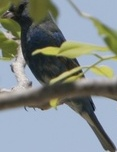

64302e7bfb63c6665d1f5be6615ff714    class = 3 vs 1 vs 1


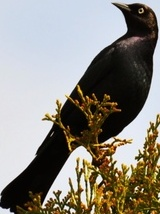

1b62fffcbf47a4f9e32b400edc662f1f    class = 3 vs 16 vs 16


4d0abdf25ded6709040bb1a9a41edfbe    class = 3 vs 0 vs 3


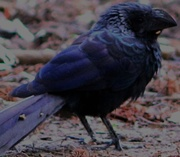

cc17c00e53ba71456ca41f2ce568e87e    class = 3 vs 13 vs 3


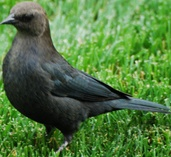

a65445216a669d870645f669ba2438e1    class = 3 vs 1 vs 3


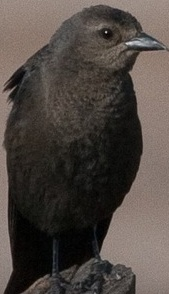

222b70d1944b7bb50b41c93962535967    class = 16 vs 15 vs 16


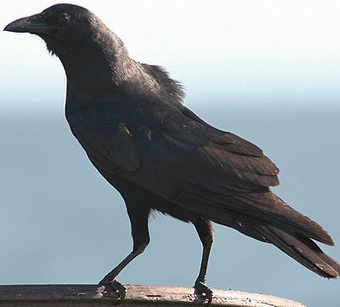

cadb9e4da9f48919c21082ab9e948ceb    class = 3 vs 13 vs 3


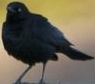

54fcf8d8ca6a7b6cec5c200f951598f9    class = 3 vs 1 vs 3


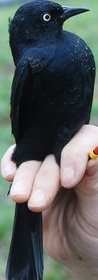

8ede0bc5a4976385dcfe6e38feaf90c2    class = 16 vs 0 vs 14


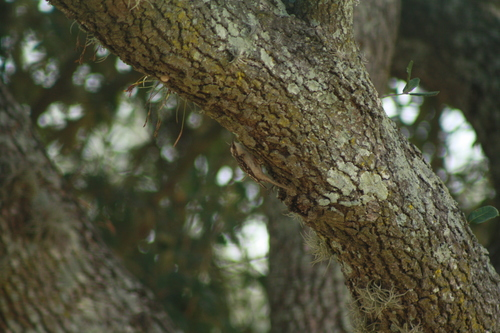

f530b89a6486d5cc8fe20cf1178ff150    class = 3 vs 1 vs 1


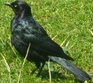

574f7b42ff837a315406e6340d0fc54b    class = 3 vs 1 vs 3


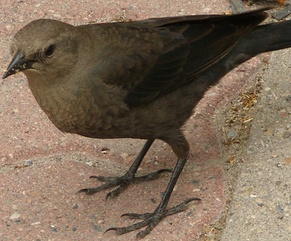

a2706ca5c2d1e8af4c1698e44987c5ed    class = 3 vs 1 vs 1


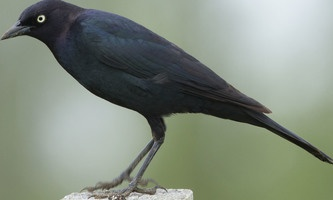

0b7b64c3eeae20e8f71923914a8643ef    class = 3 vs 1 vs 1


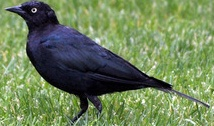

28375cb44f99643a7d8898b3d6efa20f    class = 3 vs 1 vs 3


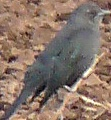

3b567146f9148617c5fbed9b346e5bb1    class = 16 vs 15 vs 16


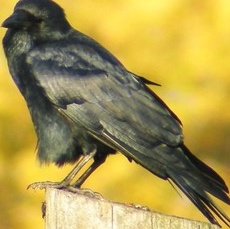

948f7030daa5e98b8f183bc7e5507923    class = 3 vs 13 vs 3


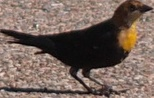

d08b43687503170c36402386df6a490f    class = 2 vs 4 vs 2


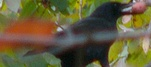

In [67]:
indeces = [42,53,55,81,85,132,180,287,296,333,334,390,425,457,464,476,477,508]
[1,0,12,?,1, ]
for i in indeces:
  img = data_file.iloc[i]["Id"]
  c = data_file.iloc[i]["Category"]
  c2 = data_file2.iloc[i]["Category"]
  c3 = data_file3.iloc[i]["Category"]
  print(f'{img}    class = {c} vs {c2} vs {c3}')
  cv2_imshow(cv2.imread(f'{test_dir}/{img}.jpg'))